In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Any

from sklearn.metrics import r2_score

In [5]:
def initialize_params(dims: int) -> np.ndarray:
    """初始化模型参数

    Args:
        dims (int): 训练数据变量维度 (特征数量)

    Returns:
        np.ndarray: 含有权重和偏置的矩阵，其形状为 n + 1 x 1，n为特征的数量
    """
    return np.zeros((dims + 1, 1))

In [6]:
def l1_loss(
    X: np.ndarray,
    y: np.ndarray,
    w_hat: np.ndarray,
    alpha: float
) -> tuple[np.ndarray, float, np.ndarray, float]:
    """计算 LASSO 回归的预测值、L1 损失和梯度

    Args:
        X (np.ndarray): 输入变量矩阵
        y (np.ndarray): 输出标签向量
        w_hat (np.ndarray): 权重矩阵
        alpha (float): 正则化系数 (lambda)

    Returns:
        tuple[np.ndarray, float, np.ndarray, float]:
            y_hat: 线性模型预测输出
            loss: 均方损失值 + L1 正则化项
            grad: 权重 w 的梯度和偏置 b 的梯度组成的矩阵
    """
    X_b = np.hstack((X, np.ones((X.shape[0], 1))))

    y_hat = X_b @ w_hat

    loss = np.mean((y_hat - y) ** 2) + np.sum(alpha * np.abs(w_hat[:-1]))

    dw = (X.T @ (y_hat - y))/ X.shape[0] + alpha * np.sign(w_hat[:-1])

    db = np.mean(y_hat - y)

    grad = np.vstack((dw, db))

    return y_hat, loss, grad

In [7]:
def lasso_train(
    X: np.ndarray,
    y: np.ndarray,
    learning_rate: float = 0.01,
    epochs: int = 1000
) -> tuple[list[float], dict[str, Any], dict[str, Any]]:

    """定义 LASSO 回归模型的训练过程

    Args:
        X (np.ndarray): 输入变量矩阵
        y (np.ndarray): 输出标签向量
        learning_rate (float, optional): 学习率. Defaults to 0.01.
        epochs (int, optional): 训练迭代次数. Defaults to 1000.

    Returns:
        tuple[list[float], dict[str, Any], dict[str, Any]]:
            loss_his: 每次迭代的 L1 损失列表
            params: 优化后的参数矩阵
            grad: 优化后的参数梯度矩阵
    """

    params = initialize_params(X.shape[1])

    loss_his = []
    for epoch in range(epochs):
        y_hat, loss, grad = l1_loss(X, y, params, 0.1)

        params = params - grad * learning_rate

        loss_his.append(loss)

    return loss_his, params, grad

In [8]:
def predict(X:np.ndarray, params:np.ndarray) -> np.ndarray:
    """预测函数

    Args:
        X (np.ndarray): 用于预测的变量
        params (np.ndarray): 用于预测的参数

    Returns:
        np.ndarray: 预测结果
    """
    X_b = np.hstack((X, np.ones((X.shape[0], 1))))

    y_pred = np.dot(X_b, params)
    return y_pred

In [10]:
data = np.genfromtxt('example.dat', delimiter=',')

# 选择特征与标签
x = data[:,0:100]
y = data[:,100].reshape(-1,1)
# 加一列
X = np.column_stack((np.ones((x.shape[0],1)),x))

# 划分训练集与测试集
X_train, y_train = X[:70], y[:70]
X_test, y_test = X[70:], y[70:]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(70, 101) (70, 1) (31, 101) (31, 1)


In [ ]:
loss_list, params, grads = lasso_train(X_train, y_train, 0.01, 3000)

y_pred = predict(X_test, params)

[[ 0.24671]
 [-4.25711]
 [ 2.38642]
 [-1.87815]
 [-3.41362]]
[[-0.44784378]
 [-2.87547152]
 [ 0.4372783 ]
 [-0.55280668]
 [-3.15629094]]


In [ ]:
print(r2_score(y_test, y_pred))

0.7801515478767684


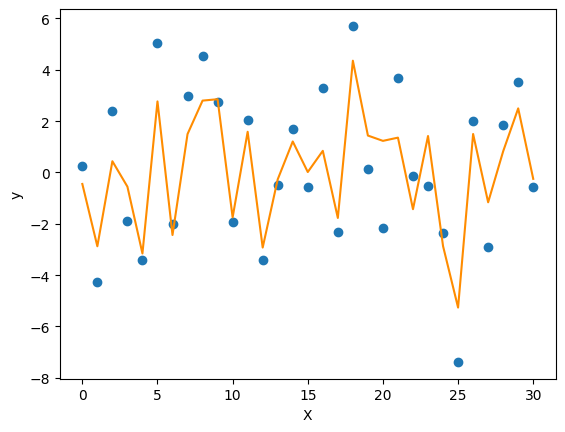

In [13]:
# 简单绘图

f = np.hstack((X_test, np.ones((X_test.shape[0], 1)))) @ params

plt.scatter(range(X_test.shape[0]), y_test)
plt.plot(f, color = 'darkorange')
plt.xlabel('X')
plt.ylabel('y')
plt.show();

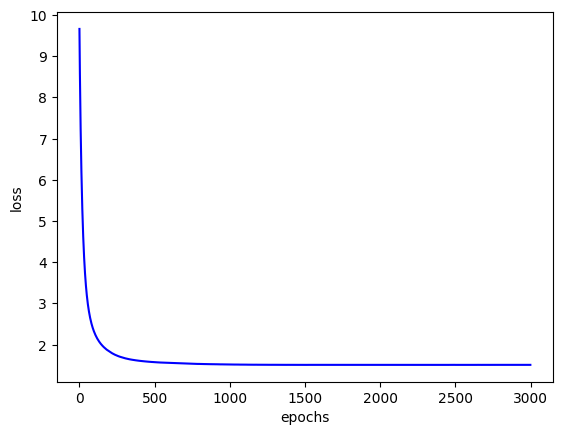

In [14]:
# 训练过程中的损失下降
plt.plot(loss_list, color = 'blue')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()